## 1. Business Questions


1. How much am I spending on Facebook?
2. How many leads am I getting per campaign / per project / per day?
3. What is my Cost per Lead (CPL)?
4. Which campaigns generate many leads but low conversion?
5. Which projects are performing best in terms of lead quality?
6. On which days is performance (leads / conversions) the best?
7. Which campaigns should I pause or scale based on cost and conversion?

# 🧩 Import & Load & Basic Cleaning

In [1]:
import pandas as pd
import numpy as np

# Load datasets
campaign_leads = pd.read_csv("campaign_leads.csv")
campaigns = pd.read_csv("campaigns.csv")
insights = pd.read_csv("insights.csv")
lead_status_changes = pd.read_csv("lead_status_changes.csv")

# Remove duplicates
insights = insights.drop_duplicates()
lead_status_changes = lead_status_changes.drop_duplicates()

# Convert dates to datetime
campaign_leads["added_date"] = pd.to_datetime(campaign_leads["added_date"])
insights["created_at"] = pd.to_datetime(insights["created_at"])
lead_status_changes["created_at"] = pd.to_datetime(lead_status_changes["created_at"])

# Define conversion statuses
conversion_statuses = [
    "DONE_DEAL", "ALREADY_BOUGHT", "MEETING_DONE",
    "QUALIFIED", "HIGH_INTEREST", "RESALE_REQUEST"
]

# Add flag for converted lead
campaign_leads["is_converted"] = campaign_leads["lead_status"].isin(conversion_statuses)


# 🧩 Dataset Joins

In [2]:
# Merge leads with campaigns (to bring project_name and user_id)
leads_with_campaign = campaign_leads.merge(
    campaigns[["id", "project_name", "user_id"]],
    left_on="campaign_id", right_on="id",
    how="left",
    suffixes=("_lead", "_campaign")
)

# Merge insights with campaigns (to bring project_name and user_id)
insights_with_campaign = insights.merge(
    campaigns[["id", "project_name", "user_id"]],
    left_on="campaign_id", right_on="id",
    how="left",
    suffixes=("_insight", "_campaign")
)

leads_with_campaign.head(), insights_with_campaign.head()


(   id_lead  campaign_id                   name                       email  \
 0    77930         6496         Vicky Mohr Sr.      smith.oren@example.org   
 1    77942         6496         Clovis Mueller       toy.korey@example.net   
 2    77964         6493     Austin Ondricka II           hveum@example.org   
 3    77983         6500            Jaquan Kuhn  greenholt.elsa@example.com   
 4    77988         6496  Prof. Grayson Collier          obie83@example.com   
 
              phone    lead_status          added_date  is_converted  \
 0   +2015628437879        UNKNOWN 2024-06-01 17:00:40         False   
 1  +1-615-909-5723        UNKNOWN 2024-06-01 18:22:00         False   
 2   +2014034035897  NOT_QUALIFIED 2024-06-01 21:56:33         False   
 3     310-242-6257        UNKNOWN 2024-06-02 01:13:19         False   
 4   +2016402961934        UNKNOWN 2024-06-02 01:41:56         False   
 
    id_campaign                   project_name  user_id  
 0         6496     Il Cazar Saf

# 🧩 Step 3 – Overview KPIs (Spend, Leads, Conversion)

In [3]:
# Total metrics
total_spend = insights["spend"].sum()
total_leads = len(campaign_leads)
total_converted = campaign_leads["is_converted"].sum()
conversion_rate = total_converted / total_leads

overview_kpis = {
    "Total Spend": total_spend,
    "Total Leads": total_leads,
    "Converted Leads": total_converted,
    "Overall Conversion Rate": conversion_rate
}

overview_kpis


{'Total Spend': np.float64(24847745.869999997),
 'Total Leads': 56965,
 'Converted Leads': np.int64(4436),
 'Overall Conversion Rate': np.float64(0.07787237777582726)}

# 🧩 Step 4 – Campaign-level Performance (CPL & Conversion per Campaign)

In [4]:
# Leads per campaign
leads_per_campaign = campaign_leads.groupby("campaign_id").agg(
    total_leads=("id", "count"),
    converted_leads=("is_converted", "sum")
)

leads_per_campaign["conversion_rate"] = (
    leads_per_campaign["converted_leads"] / leads_per_campaign["total_leads"]
)

# Spend per campaign
spend_per_campaign = insights.groupby("campaign_id")["spend"].sum()

# Join
campaign_perf = leads_per_campaign.join(spend_per_campaign, how="left")

# Cost per lead & cost per conversion
campaign_perf["CPL"] = campaign_perf["spend"] / campaign_perf["total_leads"]
campaign_perf["cost_per_conversion"] = (
    campaign_perf["spend"] / campaign_perf["converted_leads"].replace(0, np.nan)
)

campaign_perf.head()


,total_leads,converted_leads,conversion_rate,spend,CPL,cost_per_conversion
campaign_id,,,,,,
6493,1,0,0.0,689.19,689.1900,NaN
6496,4,0,0.0,2137.86,534.4650,NaN
6497,1,0,0.0,888.43,888.4300,NaN
6500,1,0,0.0,842.40,842.4000,NaN
6502,4,0,0.0,1532.13,383.0325,NaN


In [6]:
# Best campaigns by conversion rate (with at least 20 leads)
best_campaigns = campaign_perf[campaign_perf["total_leads"] >= 20].sort_values(
    "conversion_rate", ascending=False
).head(10)

# Worst campaigns by CPL (with at least 20 leads)
worst_campaigns = campaign_perf[campaign_perf["total_leads"] >= 20].sort_values(
    "CPL", ascending=False
).head(10)

best_campaigns 


,total_leads,converted_leads,conversion_rate,spend,CPL,cost_per_conversion
campaign_id,,,,,,
8770,48,48,1.000000,4850.94,101.061250,101.061250
8521,99,99,1.000000,6504.34,65.700404,65.700404
8520,38,37,0.973684,1603.68,42.202105,43.342703
8237,37,20,0.540541,14158.61,382.665135,707.930500
8840,22,11,0.500000,4626.25,210.284091,420.568182
6728,40,20,0.500000,17140.12,428.503000,857.006000
7382,61,30,0.491803,6368.00,104.393443,212.266667
6605,47,23,0.489362,7232.67,153.886596,314.463913
7860,76,36,0.473684,10630.47,139.874605,295.290833


In [7]:
worst_campaigns

,total_leads,converted_leads,conversion_rate,spend,CPL,cost_per_conversion
campaign_id,,,,,,
15208,86,0,0.0,1083226.89,12595.661512,NaN
15228,144,0,0.0,1246692.60,8657.587500,NaN
12685,29,0,0.0,41571.20,1433.489655,NaN
8717,28,0,0.0,39927.00,1425.964286,NaN
12680,34,0,0.0,42093.92,1238.056471,NaN
14159,67,0,0.0,68870.28,1027.914627,NaN
14707,24,0,0.0,23913.11,996.379583,NaN
8882,25,0,0.0,22053.11,882.124400,NaN
9450,23,0,0.0,20082.97,873.172609,NaN


# 🧩 Step 5 – Project-level Performance

In [9]:
# Aggregate leads by project
project_leads = leads_with_campaign.groupby("project_name").agg(
    total_leads=("id_lead", "count"),
    converted_leads=("is_converted", "sum")
)

project_leads["conversion_rate"] = (
    project_leads["converted_leads"] / project_leads["total_leads"]
)

# Aggregate spend by project
project_spend = insights_with_campaign.groupby("project_name")["spend"].sum()

# Join
project_perf = project_leads.join(project_spend, how="left")

# Cost per lead
project_perf["CPL"] = project_perf["spend"] / project_perf["total_leads"]

project_perf.sort_values("conversion_rate", ascending=False).head()


,total_leads,converted_leads,conversion_rate,spend,CPL
project_name,,,,,
Veranda Sahl Hasheesh,234,194,0.829060,31638.51,135.207308
⁠Pearl - SUD - New Mansoura,2,1,0.500000,6277.15,3138.575000
[East] Bayty exhibition - address investment,9,4,0.444444,2237.18,248.575556
Silversands - Ora Developments,147,63,0.428571,28259.55,192.241837
Kai Sokhna,7,3,0.428571,3796.52,542.360000


# 🧩 Step 6 – Daily Performance (Spend, Leads, Conversion over time)

In [12]:
# Ensure we use just dates (not full timestamps)
insights["date"] = insights["created_at"].dt.date
campaign_leads["date"] = campaign_leads["added_date"].dt.date

# Daily spend
daily_spend = insights.groupby("date")["spend"].sum()

# Daily leads & conversion
daily_leads = campaign_leads.groupby("date")["id"].count()
daily_conversion_rate = campaign_leads.groupby("date")["is_converted"].mean()

daily_summary = pd.DataFrame({
    "daily_spend": daily_spend,
    "daily_leads": daily_leads,
    "daily_conversion_rate": daily_conversion_rate
}).reset_index()

daily_summary.head()


,date,daily_spend,daily_leads,daily_conversion_rate
0,2024-06-01,1128.18,3.0,0.000000
1,2024-06-02,6150.82,15.0,0.066667
2,2024-06-03,10577.59,16.0,0.062500
3,2024-06-04,21335.50,34.0,0.088235
4,2024-06-05,23800.47,50.0,0.040000


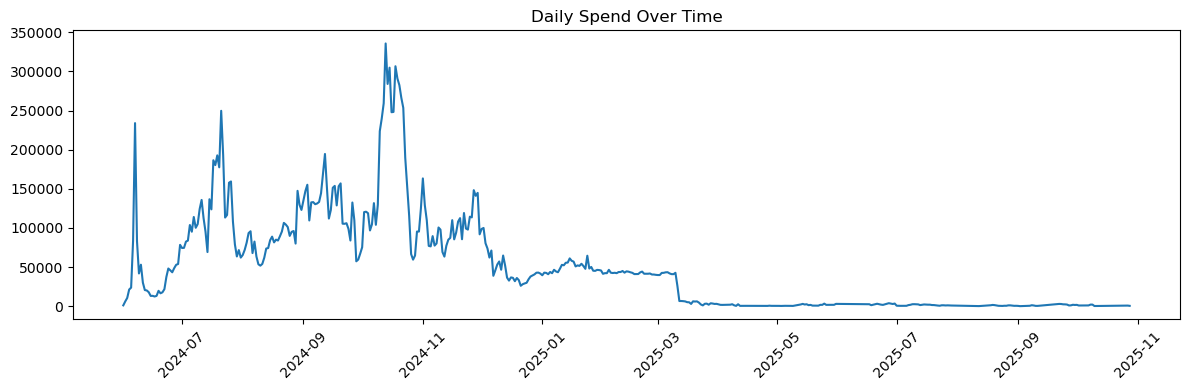

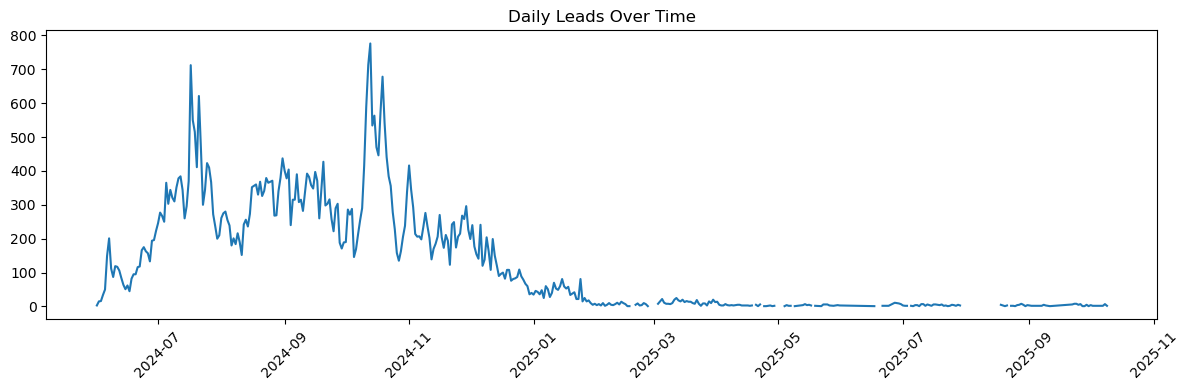

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(daily_summary["date"], daily_summary["daily_spend"])
plt.title("Daily Spend Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(daily_summary["date"], daily_summary["daily_leads"])
plt.title("Daily Leads Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 🧩 Step 7 – Lead Funnel

In [14]:
lead_status_counts = campaign_leads["lead_status"].value_counts().reset_index()
lead_status_counts.columns = ["lead_status", "count"]
lead_status_counts


,lead_status,count
0,UNKNOWN,27582
1,NEW_LEAD,14724
2,QUALIFIED,4063
3,NO_ANSWER,3124
4,NOT_QUALIFIED,2821
5,CALL_AGAIN,923
6,FOLLOW_UP,921
7,WHATSAPP,844
8,LOW_BUDGET,547
9,SWITCHED_OFF,440


In [17]:
print(filtered_leads.columns.tolist())
print(filtered_leads.head())


['id_lead', 'campaign_id', 'name', 'email', 'phone', 'lead_status', 'added_date', 'is_converted', 'id_campaign', 'project_name', 'user_id']
   id_lead  campaign_id                   name                       email  \
0    77930         6496         Vicky Mohr Sr.      smith.oren@example.org   
1    77942         6496         Clovis Mueller       toy.korey@example.net   
2    77964         6493     Austin Ondricka II           hveum@example.org   
3    77983         6500            Jaquan Kuhn  greenholt.elsa@example.com   
4    77988         6496  Prof. Grayson Collier          obie83@example.com   

             phone    lead_status          added_date  is_converted  \
0   +2015628437879        UNKNOWN 2024-06-01 17:00:40         False   
1  +1-615-909-5723        UNKNOWN 2024-06-01 18:22:00         False   
2   +2014034035897  NOT_QUALIFIED 2024-06-01 21:56:33         False   
3     310-242-6257        UNKNOWN 2024-06-02 01:13:19         False   
4   +2016402961934        UNKNOWN 20